In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
try:
  import einops
  from einops import rearrange,reduce,repeat,einsum
except ImportError:
  os.system('pip install einops')
  from einops import rearrange,reduce,repeat,einsum
import math
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,CosineAnnealingLR
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CLinear(nn.Module):
  def __init__(self,input_dim,out_dim,bias=True):
    super().__init__()
    self.input_dim=input_dim
    self.out_dim=out_dim
    self.weights_1=nn.Parameter(torch.randn(size=(1,input_dim,1)))

    self.weights_2=nn.Parameter(torch.randn(size=(out_dim,1,1)))
    self.bias=nn.Parameter(torch.randn(size=(out_dim,))) if bias==True else None


  def forward(self,x):

    x=rearrange(tensor=x,pattern="B T D -> B D T")

    x=F.conv1d(input=x,weight=self.weights_1,bias=None,stride=1)

    x= F.conv1d(input=x,weight=self.weights_2,bias=self.bias,stride=1)

    x=rearrange(tensor=x,pattern="B D T -> B T D")
    return x

def Sinusoidal_position_Emdedding(length=1024,d_model=768,learnable=False,device="cpu"):
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return nn.Parameter(pe).to(device) if learnable else pe.to(device)

class Relative_position_embedding(nn.Module):

  def __init__(self,head_dim,k,device):
    super().__init__()
    self.head_dim=head_dim
    self.k=k

    self.device=device
    self.position=Sinusoidal_position_Emdedding(self.k*2+1,head_dim,learnable=False,device=self.device)

  def forward(self,q_len,k_len):
    vec_q=torch.arange(q_len)
    vec_k=torch.arange(k_len)
    distance_mat= vec_k[None,:] - vec_q[:,None]
    clipped_distance=torch.clamp(distance_mat,-self.k,self.k)
    final_mat= clipped_distance + self.k
    final_mat = torch.LongTensor(final_mat).to(self.device)
    embeddings=self.position[final_mat].to(self.device)

    return embeddings


def gqa(query,key,value,group,num_head,dropout=0.):

  scale=query.size(-1)**0.5

  query=query/scale

  b,hq,t,d=query.shape
  b,hk,s,d=key.shape

  num_head_groups= num_head//group


  query=rearrange(query,"b (h g) n d -> b g h n d",g=num_head_groups)

  attn=einsum(query, key, "b g h n d,b h s d -> b g h n s")

  mask=torch.ones((b,t,s),device=query.device,dtype=torch.bool).tril_()

  if mask is not None:
    if mask.ndim == 2:
        mask = rearrange(mask, "b s -> b () () () s")
    elif mask.ndim == 3:
        mask = rearrange(mask, "b n s -> b () () n s")

  attn.masked_fill_(~mask,torch.finfo(attn.dtype).min)
  attn=F.softmax(attn,dim=-1)

  attn=F.dropout(attn,p=dropout)

  attn=einsum(attn,value,"b g h t s, b h s d -> b g h t d")
  attn=rearrange(attn,"b g h t d -> b (g h) t d")

  return attn



class MultiAttention(nn.Module):
  def __init__(self,mode="MHA",group=2,attention_dropout=0.,num_heads=4,dim=768,device="cuda",relative_pos=False):
    super().__init__()
    assert dim%num_heads==0 and num_heads%group==0
    self.num_heads=num_heads
    self.dim=dim
    self.device=device

    self.query=nn.Linear(dim,dim)

    self.k=50

    self.mode=mode

    self.group=num_heads if mode=="MHA" else 1 if mode=="MQA" else group

    self.key= nn.Linear(dim,(dim//num_heads)*self.group)

    self.value=nn.Linear(dim,(dim//num_heads)*self.group)


    self.relative_position_k=Relative_position_embedding(self.dim//self.num_heads,self.k,self.device)
    self.relative_position_v= Relative_position_embedding(self.dim//self.num_heads,self.k,self.device)
    self.relative_pos=relative_pos
    self.attention_dropout=attention_dropout
    self.out=nn.Linear(dim,dim)

  def forward(self,x):

    query=rearrange(self.query(x),"b t (h d) -> b h t d",h=self.num_heads)
    key=rearrange(self.key(x),"b s (h d) -> b h s d",h=self.group)
    value=rearrange(self.value(x),"b s (h d) -> b h s d",h=self.group)
    if self.group==1:
      self.mode="MQA"

    if self.mode=="GQA":
      attn1=gqa(query,key,value,num_head=self.num_heads,group=self.group)

    elif self.mode=="MQA":
      assert self.group==1
      attn1=gqa(query,key,value,num_head=self.num_heads,group=self.group)
    else:
      attn1=F.scaled_dot_product_attention(query,key,value,dropout_p=self.attention_dropout,is_causal=True)

    """Relational Positional embedding"""
    if self.relative_pos:
      len_q=query.shape[2]
      len_k=key.shape[2]
      len_v=value.shape[2]

      relative_positionk=self.relative_position_k(len_q,len_k)
      relative_positionv=self.relative_position_v(len_q,len_v)



    if self.relative_pos:
      r_q=rearrange(tensor=query,pattern='B N T D -> T (B N) D')
      attn2=(r_q@relative_positionk.transpose(1,2)).transpose(0,1)
      attn2=rearrange(tensor=attn2,pattern="(B N) Q K -> B N Q K",N=self.num_heads)
      mask=torch.ones((len_q,len_k),device=query.device,dtype=torch.bool).tril_()

      attn2=attn2.masked_fill(mask[:len_q,:len_k]==0,float('-inf'))

      scale=(self.dim//self.num_heads)**-0.5
      attn2=attn2*scale
      attn2=F.softmax(attn2,dim=-1)
      attn2=rearrange(tensor=attn2,pattern="B N Q K -> Q (B N) K")
      attn2=(attn2@relative_positionv).transpose(0,1)
      attn2=rearrange(tensor=attn2,pattern="(B N) Q D -> B N Q D",N=self.num_heads)

      attn2=F.dropout(attn2,p=self.attention_dropout)

      attn = attn1 + attn2
    else:
      attn=attn1

    attn=rearrange(tensor=attn,pattern="B N T D-> B T (D N)",N=self.num_heads)

    a=self.out(attn)
    return a

class SHA(nn.Module):
  def __init__(self,dim,attention_dropout):
    super().__init__()

    self.qkv=nn.Linear(dim,dim*3)
    self.attention_dropout=attention_dropout

  def forward(self,x):
    qkv=self.qkv(x)
    qkv=rearrange(tensor=qkv,pattern="B T (D N) ->  N B T D",N=3)
    q,k,v=qkv[0],qkv[1],qkv[2]

    return F.scaled_dot_product_attention(q,k,v,dropout_p=self.attention_dropout,is_causal=True)


class MLP(nn.Module):
  def __init__(self,input_dim,out_dim):
    super().__init__()
    self.input_dim=input_dim
    self.out_dim=out_dim
    self.act=nn.GELU()

    self.mlp=nn.Sequential(
      nn.Linear(input_dim,out_dim*4),
      nn.GELU(),
      nn.Linear(out_dim*4,out_dim)
    )

  def forward(self,x):
    return self.mlp(x)

In [ ]:
def Sinusoidal_position_Emdedding(length=1024,d_model=768,learnable=False,device="cuda"):
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)
    pe=pe.to(device)
    return nn.Parameter(pe) if learnable else pe

In [ ]:
class Prediction_heads(nn.Module):
  def __init__(self,dim,attention_dropout=0.0,n_tokens=2):
    super().__init__()
    self.independent_heads=nn.ModuleList(
        [SHA(dim=dim,attention_dropout=attention_dropout) for _ in range(n_tokens)]
    )
  def __call__(self):
    return self.independent_heads


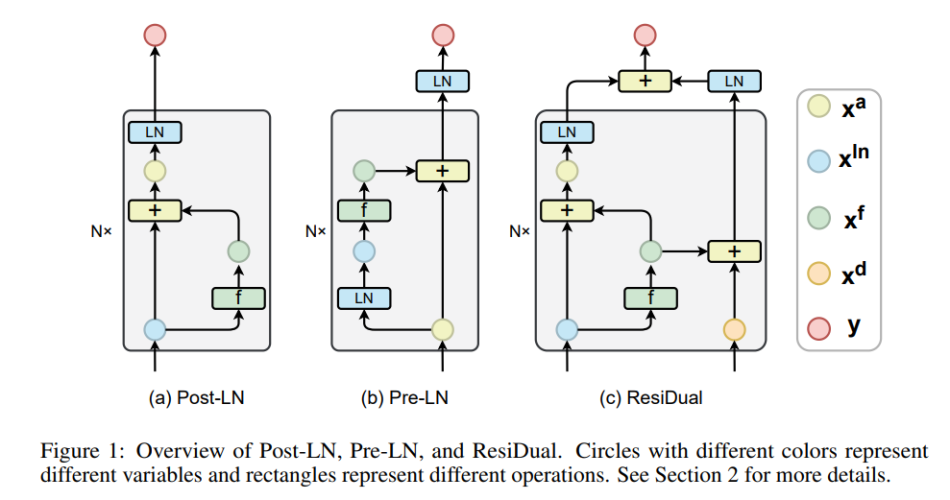

In [ ]:
class ResiDual(nn.Module):
  def __init__(self,dim,net):
    super().__init__()
    self.dim=dim
    self.net=net
    self.ln1=nn.LayerNorm(dim)
    self.ln2=nn.LayerNorm(dim)
  def forward(self,xln,xd=None):
    xnet=self.net(xln)

    if xd!=None:
      xd=xd+xnet
    else:
      xd=xnet

    xln=xln+xnet

    xln=self.ln1(xln)
    xd=self.ln2(xd)

    return xln+xd,xd

In [ ]:
class Block(nn.Module):
  def __init__(self,mode="GQA",group=2,n_heads=4,attention_dropout=0,dim=1024,relative_pe=False,device="cuda"):
    super().__init__()
    self.dim=dim
    self.n_heads=n_heads
    self.layer_norm1=nn.LayerNorm(dim)
    self.layer_norm2=nn.LayerNorm(dim)
    self.attn=MultiAttention(mode=mode,group=group,num_heads=n_heads,dim=dim,attention_dropout=attention_dropout,relative_pos=relative_pe,device=device)
    self.mlp=MLP(dim,dim)

  def forward(self,x):
    x=x+self.attn(self.layer_norm1(x))
    x=x+self.mlp(self.layer_norm2(x))

    return x

In [ ]:
class LLM_Maybe(nn.Module):
  def __init__(self,embedding_dimensions,embedding_layer,n_tokens=2,n_layers=8,mode="MHA",group=2,attention_dropout=0.,num_heads=4,dim=768,device="cuda"):

    super().__init__()
    self.dim=dim
    self.n_layers=n_layers
    self.num_heads=num_heads
    self.n_tokens=n_tokens
    self.embedding_dimensions=embedding_dimensions
    self.embed_layer=embedding_layer.to(device)
    self.device=device

    self.blocks=nn.ModuleList([
        Block(mode=mode,group=group,n_heads=num_heads,attention_dropout=0.,dim=dim) for _ in range(self.n_layers)
    ])

    self.independent_heads=nn.ModuleList(
        [SHA(dim=dim,attention_dropout=attention_dropout) for _ in range(n_tokens)]
    )

    self.un_embed_layer=nn.Linear(self.dim,embedding_dimensions,bias=False)
    self.embed_layer.weight=self.un_embed_layer.weight

    self.embed_layer.weight.data_ptr=self.un_embed_layer.weight.data_ptr

    for i in self.embed_layer.parameters():
      i.requires_grad=False

    #self.un_embed_layer.requires_grad=False
    self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            std*=(2*self.n_layers) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module,CLinear):
            std = 0.02
            std*=(2 * self.n_layers) ** -0.5
            torch.nn.init.normal_(module.weights_1, mean=0.0, std=std)
            torch.nn.init.normal_(module.weights_1, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        """elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)"""

  def forward_trunk(self,x):
    x=self.embed_layer(x)

    B,T,D=x.shape

    x_pos=Sinusoidal_position_Emdedding(T,d_model=1024,device=self.device)

    x = x + x_pos
    y=x
    for i in range(self.n_layers):
      y=self.blocks[i](y)


    return y



  def fpass_independent_heads(self,head,x,y):
    #B T D=X, B T V=p B T=Y

    p=self.independent_heads[head](x)
    p=self.un_embed_layer(p)

    B,T,V=p.shape
    return p,F.cross_entropy(p.view(-1,V),y.view(-1,))

  def infer_independent_heads(self,x):
    for head in range(self.n_tokens):
      if head==0:
        logits=self.independent_heads[head](x)[:,-1,:]
        tokens=torch.argmax(logits,dim=-1)
        tokens=tokens.unsqueeze(0)
      else:
        current_logit=self.independent_heads[head](x)[:,-1,:]
        current_tokens=torch.argmax(current_logit,dim=-1)
        current_tokens=current_tokens.unsqueeze(0)
        print(logits.shape,current_logit.shape,current_tokens.shape,tokens.shape)
        logits=torch.stack([logits,current_logit],dim=1) # B N D
        tokens=torch.cat([tokens,current_tokens],dim=-1) # B T+N

    return tokens,logits



  def forward(self,x):
    z=self.forward_trunk(x)
    d=z.detach()
    d.requires_grad=True
    return d,z


  #Evaluvate after backprop
  def greedy_self_speculative_sampling(self,x,length,device):
    T=length
    n=0
    while n<T:
      with torch.autocast(device_type=device,dtype=torch.bfloat16):
            logits,_=self.forward(x)

      #predict n_tokens
      tokens,logits=self.infer_independent_heads(logits)
      print(tokens.shape,"logits",logits.shape)
      #verify on with first head
      predict=self.independent_heads[0](
          torch.cat([x,tokens],dim=-1)
          )

      first_head_logits = self.un_embed_layer(predict)
      first_head_logits = first_head_logits[:,-len(tokens):,:]

      predict_token  = first_head_logits.argmax(dim=-1)
      final_accepted = tuple((tokens==predict_token).nonzero()[-1])
      _,accepted_tokens=final_accepted

      x=torch.cat([x,tokens[:final_accepted.item()]],dim=1)
      n+=len(tokens[:final_accepted.item()])

    return x

  def sampling_on_one_head(self,x,length,top_k=5,device="cuda"):
    with torch.no_grad():
      for i in range(length):
        with torch.autocast(device_type=device,dtype=torch.bfloat16):
            logits,_=model(x)

        logits=self.independent_heads[0](logits)
        logits = self.un_embed_layer(logits)
        probs=torch.nn.functional.softmax(logits[:,-1,:],dim=-1)

        topk_values,topk_indices = torch.topk(probs,5,dim=-1)
        topk_values=topk_values.squeeze(0)
        topk_indices=topk_indices.squeeze(0)

        ix=torch.multinomial(topk_values,1)

        xcol=torch.gather(topk_indices,-1,ix)

        xcol=xcol.unsqueeze(0)
        x=torch.cat([x,xcol],dim=1)
      return x

## Copying Tokenizer and Embedding Layers :) from Indic BART because you can extend this same model to pretrain on Multilingual corpus Easily and embedding Layer takes significant ammount of parameter by just copying and freezing I could get better representation (than random init) for free. Always better to do your own embedding layer and tokenizer but we are speaking of fitting the entire model in T4 GPU

In [ ]:
from transformers import AlbertTokenizer, MBartForConditionalGeneration

tokenizer = AlbertTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

model = MBartForConditionalGeneration.from_pretrained("ai4bharat/IndicBART")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
embedding_layer=model.model.encoder.embed_tokens
embedding_dimension,transformer_dimension=embedding_layer.weight.shape

In [ ]:
model=LLM_Maybe(embedding_layer=embedding_layer,embedding_dimensions=embedding_dimension,n_layers=3,dim=transformer_dimension,mode="GQA",num_heads=16,group=2,n_tokens=2,device='cuda')
model=model.cuda()

In [ ]:
total_parameters=sum([i.numel() for i in model.parameters() if i.requires_grad ])
total_parameters

38575872

In [ ]:
!git clone https://github.com/rahulvks/ponniyin-selvan-

fatal: destination path 'ponniyin-selvan-' already exists and is not an empty directory.


In [ ]:
from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import os
import glob
import numpy as np
import pickle
from tqdm.notebook import tqdm
def sorted_value(x):
  return float(x.split('/')[-2].split('-')[-1]),int(x.split('/')[-1].split('_')[-1].split('.')[0])
text_files = sorted(glob.glob('/content/ponniyin-selvan-/**/*.txt'),key=sorted_value)
total_corpus=''
numpy_tokens=[]
for file in text_files:
  with open(file,'r') as f:
    words=f.readline()
    words=words.split(' ')[3:]
    current_word= ' '.join(words)
    arr=tokenizer(current_word,add_special_tokens=False).input_ids
    numpy_tokens=arr if numpy_tokens==[] else numpy_tokens+arr

numpy_tokens=np.array(numpy_tokens,dtype=np.int32)
with open('tokens.npy','wb') as f:
  np.save(f,numpy_tokens)

In [ ]:
with open('tokens.npy','rb') as f:
   corpus_tokenized=np.load(f)

In [ ]:
class Dataset():
  def __init__(self,B,T,n_tokens,corpus_tokenized):
    self.B=B
    self.T=T
    self.corpus=corpus_tokenized
    self.pointer=0
    self.n_tokens=n_tokens
    self.total_iterations= corpus_tokenized.shape[0]//((B*T) + self.n_tokens)
  def get_batch(self):
    buffer=self.corpus[self.pointer:self.pointer+(self.B*self.T)+self.n_tokens]

    self.pointer+=(self.B*self.T)+self.n_tokens

    if self.pointer + (self.B*self.T)+self.n_tokens >=self.corpus.shape[0]:
      self.pointer=0
      print("fin starting over")
    return torch.tensor(buffer,dtype=torch.long)

In [ ]:
len(corpus_tokenized)

3647424

In [ ]:
#Sanity check where all trains correctly
B=8
T=256
n_tokens=2
train_loader=Dataset(B=B,T=T,n_tokens=2,corpus_tokenized=corpus_tokenized)

In [ ]:
optimizer=torch.optim.AdamW(model.parameters(),1*10e-3,betas=(0.9,0.95),weight_decay=0.01)

In [ ]:
for name,value in model.named_parameters():
  print(name)

embed_layer.weight
blocks.0.layer_norm1.weight
blocks.0.layer_norm1.bias
blocks.0.layer_norm2.weight
blocks.0.layer_norm2.bias
blocks.0.attn.query.weight
blocks.0.attn.query.bias
blocks.0.attn.key.weight
blocks.0.attn.key.bias
blocks.0.attn.value.weight
blocks.0.attn.value.bias
blocks.0.attn.out.weight
blocks.0.attn.out.bias
blocks.0.mlp.mlp.0.weight
blocks.0.mlp.mlp.0.bias
blocks.0.mlp.mlp.2.weight
blocks.0.mlp.mlp.2.bias
blocks.1.layer_norm1.weight
blocks.1.layer_norm1.bias
blocks.1.layer_norm2.weight
blocks.1.layer_norm2.bias
blocks.1.attn.query.weight
blocks.1.attn.query.bias
blocks.1.attn.key.weight
blocks.1.attn.key.bias
blocks.1.attn.value.weight
blocks.1.attn.value.bias
blocks.1.attn.out.weight
blocks.1.attn.out.bias
blocks.1.mlp.mlp.0.weight
blocks.1.mlp.mlp.0.bias
blocks.1.mlp.mlp.2.weight
blocks.1.mlp.mlp.2.bias
blocks.2.layer_norm1.weight
blocks.2.layer_norm1.bias
blocks.2.layer_norm2.weight
blocks.2.layer_norm2.bias
blocks.2.attn.query.weight
blocks.2.attn.query.bias
block

In [ ]:
log=[]
def train_loop(model,optimizer,train_loader,n_tokens,device,total_epochs=1):
    losses=[]
    epochs=0
    total_iterations=train_loader.total_iterations
    print(f"""Total Iterations of this thing is {total_iterations}""")
    current_loss=[]
    for i in range(total_epochs):
      head_loss=[0,0]
      for current_iter in tqdm(range(total_iterations)):
        buffer=train_loader.get_batch()
        x=buffer[0:(B*T)]
        x=x.view(B,T).cuda()
        accumulation_steps = 100
        lr=1e-4
        for param_group in optimizer.param_groups:
          param_group['lr'] = lr
        with torch.autocast(device_type=device,dtype=torch.bfloat16):
          d,z=model(x)
        for i in range(n_tokens):
          y=buffer[(i+1):(B*T)+(i+1)]
          y=y.view(B,T).cuda()
          with torch.autocast(device_type=device,dtype=torch.bfloat16):
            logits,loss=model.fpass_independent_heads(i,d,y)
            loss= loss / accumulation_steps
          loss.backward()
          current_loss.append(loss.item())

        z.backward(gradient=d.grad)

        if (current_iter+1)%accumulation_steps==0 or (current_iter+1)==total_iterations:


          print("Doing Gradient Decent")
          norm=torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
          optimizer.step()
          print(f"Loss Head1: {current_loss[-1]}, Head2:{current_loss[-2]} Iteration: {current_iter}")

          print("NORM and Grad accum ")

          optimizer.zero_grad()
          """Just making sure the parameters 0 because am paranoid weather it would zero the parameters"""
          for i in model.parameters():
            i.grad=None
          """Write log with indpendent heads as 0"""
        losses.append(current_loss)
        current_loss=[]
    return losses



## TODO Put Gradient Accumulation logic

In [ ]:
with torch.autograd.set_detect_anomaly(True):
  model.train()
  losses=train_loop(model=model,optimizer=optimizer,train_loader=train_loader,n_tokens=n_tokens,device="cuda",total_epochs=2)

Total Iterations of this thing is 1779


  0%|          | 0/1779 [00:00<?, ?it/s]

Doing Gradient Decent
Loss Head1: 0.11070098727941513, Head2:0.11067565530538559 Iteration: 99
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.10941436886787415, Head2:0.10928649455308914 Iteration: 199
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.10776031017303467, Head2:0.10758788883686066 Iteration: 299
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.10541991889476776, Head2:0.10509032756090164 Iteration: 399
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.10192016512155533, Head2:0.10140807926654816 Iteration: 499
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.09667067974805832, Head2:0.0958615094423294 Iteration: 599
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.08884979039430618, Head2:0.08793334662914276 Iteration: 699
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.07955688238143921, Head2:0.07909255474805832 Iteration: 799
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.07836245000362396, Head2:0.081

  0%|          | 0/1779 [00:00<?, ?it/s]

Doing Gradient Decent
Loss Head1: 0.058556973934173584, Head2:0.05817268416285515 Iteration: 99
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.05831199511885643, Head2:0.05818931385874748 Iteration: 199
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.054264143109321594, Head2:0.054347533732652664 Iteration: 299
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.054198913276195526, Head2:0.054152294993400574 Iteration: 399
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.052052419632673264, Head2:0.05192355811595917 Iteration: 499
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.0495176687836647, Head2:0.04955077916383743 Iteration: 599
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.046888332813978195, Head2:0.04674709215760231 Iteration: 699
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.0493708997964859, Head2:0.04896007478237152 Iteration: 799
NORM and Grad accum 
Doing Gradient Decent
Loss Head1: 0.045512255281209946, Head

In [ ]:
10_00_0000000//(8*32_0000)

3906

In [ ]:
torch.save(model.state_dict(),"model_parametersfinal.pt")

## Implement Self speculative decoding

In [ ]:
class LLM_Maybe(nn.Module):
  def __init__(self,embedding_dimensions,embedding_layer,n_tokens=2,n_layers=8,mode="MHA",group=2,attention_dropout=0.,num_heads=4,dim=768,device="cuda"):

    super().__init__()
    self.dim=dim
    self.n_layers=n_layers
    self.num_heads=num_heads
    self.n_tokens=n_tokens
    self.embedding_dimensions=embedding_dimensions
    self.embed_layer=embedding_layer.to(device)
    self.device=device
    self.blocks=nn.ModuleList([
        Block(mode=mode,group=group,n_heads=num_heads,attention_dropout=0.,dim=dim,device=device) for _ in range(self.n_layers)
    ])

    self.independent_heads=nn.ModuleList(
        [SHA(dim=dim,attention_dropout=attention_dropout) for _ in range(n_tokens)]
    ).to(device)

    self.un_embed_layer=nn.Linear(self.dim,embedding_dimensions,bias=False)
    self.embed_layer.weight=self.un_embed_layer.weight

    self.embed_layer.weight.data_ptr=self.un_embed_layer.weight.data_ptr

    for i in self.embed_layer.parameters():
      i.requires_grad=False

    #self.un_embed_layer.requires_grad=False
    self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            std*=(2*self.n_layers) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module,CLinear):
            std = 0.02
            std*=(2 * self.n_layers) ** -0.5
            torch.nn.init.normal_(module.weights_1, mean=0.0, std=std)
            torch.nn.init.normal_(module.weights_1, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        """elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)"""

  def forward_trunk(self,x):
    x=self.embed_layer(x)

    B,T,D=x.shape

    x_pos=Sinusoidal_position_Emdedding(T,d_model=1024,device=self.device)

    x = x + x_pos
    y=x
    for i in range(self.n_layers):
      y=self.blocks[i](y)


    return y



  def fpass_independent_heads(self,head,x,y):
    #B T D=X, B T V=p B T=Y

    p=self.independent_heads[head](x)
    p=self.un_embed_layer(p)

    B,T,V=p.shape
    return p,F.cross_entropy(p.view(-1,V),y.view(-1,))

  def infer_independent_heads(self,x):
    for head in range(self.n_tokens):
      if head==0:
        logits=self.independent_heads[head](x)[:,-1,:]
        tokens=torch.argmax(logits,dim=-1)
        tokens=tokens.unsqueeze(0)
      else:
        current_logit=self.independent_heads[head](x)[:,-1,:]
        un_embed=self.un_embed_layer(current_logit)
        current_tokens=torch.argmax(un_embed,dim=-1)
        current_tokens=current_tokens.unsqueeze(0)
        logits=torch.stack([logits,current_logit],dim=1) # B N D
        tokens=torch.cat([tokens,current_tokens],dim=-1) # B T+N

    return tokens,logits



  def forward(self,x):
    z=self.forward_trunk(x)
    d=z.detach()
    d.requires_grad=True
    return d,z


  #Evaluvate after backprop
  def greedy_self_speculative_sampling(self,x,length,device):
    T=length
    n=x.shape[1]
    while n<T:
      with torch.autocast(device_type=device,dtype=torch.bfloat16):
            logits_trunk,_=self.forward(x)

      #predict n_tokens
      tokens,logits=self.infer_independent_heads(logits_trunk)
      logits=torch.cat([logits_trunk,logits],dim=1)
      #verify on with first head
      predict=self.independent_heads[0](
          logits
          )

      first_head_logits = self.un_embed_layer(predict)
      first_head_logits = first_head_logits[:,-tokens.shape[-1]:,:]

      predict_token  = first_head_logits.argmax(dim=-1)
      final_accepted = (tokens==predict_token).nonzero(as_tuple=True)


      b,t=final_accepted

      if b.shape[0]>0:

        _,accepted_tokens=final_accepted

        x=torch.cat([x,tokens[:,accepted_tokens.detach().tolist()[-1]].unsqueeze(0)],dim=-1)

        print(accepted_tokens.detach().tolist()[-1],tokens, tokens[:,accepted_tokens.detach().tolist()[-1]])

        n+=len(tokens[:,accepted_tokens.detach().tolist()[-1]])
      else:
        x=torch.cat([x,predict_token],dim=-1)
        n+=predict_token.shape[-1]
    return x

  def sampling_on_one_head(self,x,length,top_k=5,device="cuda"):
    with torch.no_grad():
      for i in range(length):
        with torch.autocast(device_type=device,dtype=torch.bfloat16):
            logits,_=model(x)

        logits=self.independent_heads[0](logits)
        logits = self.un_embed_layer(logits)
        probs=torch.nn.functional.softmax(logits[:,-1,:],dim=-1)

        topk_values,topk_indices = torch.topk(probs,5,dim=-1)
        topk_values=topk_values.squeeze(0)
        topk_indices=topk_indices.squeeze(0)

        ix=torch.multinomial(topk_values,1)

        xcol=torch.gather(topk_indices,-1,ix)

        xcol=xcol.unsqueeze(0)
        x=torch.cat([x,xcol],dim=1)
      return x

In [ ]:
def create_model_for_infer():
  model=LLM_Maybe(embedding_layer=embedding_layer,embedding_dimensions=embedding_dimension,n_layers=3,dim=transformer_dimension,mode="GQA",num_heads=16,group=2,n_tokens=2,device='cuda')
  model.load_state_dict(torch.load("model_parametersfinal.pt"))
  model=model.cuda()
  return model

In [ ]:
model=create_model_for_infer()

In [ ]:
import numpy as np
a=np.load('tokens.npy')

In [ ]:

def decode_tokenize(x):
  return tokenizer.decode(x)


## Generate on one Head

In [ ]:
a[0:50],decode_tokenize(a[0:60])

(array([   41, 63669, 59813, 59571, 59603, 59479, 59603, 59571, 59792,
        59655, 60827, 59856, 60155, 59479, 13643,   986, 63669, 59603,
        59571,    41, 60835, 60827, 59479, 59603, 59697, 59571, 60008,
        59479, 60008, 59856, 59603,    41, 59601, 59856, 60008,    41,
        59931,     1, 60155, 59479, 60155, 59603, 59479, 59603, 59571,
        60008, 59479,    41, 59601, 60338], dtype=int32),
 'ஆடித்திருநாள்\\nஆதி அந்தமில்லாத கால வ<unk> ள்ளத்தில் கற்பனை <unk>டத்த')

In [ ]:
model.eval()
with torch.no_grad():
  token_tensor=torch.tensor(a[0:50],dtype=torch.long).cuda()
  token_tensor=token_tensor.view(1,-1)
  tokens_outs=model.sampling_on_one_head(token_tensor,length=300,device="cuda")


In [ ]:
#detach tensor
text=decode_tokenize(tokens_outs[0].detach().tolist())

In [ ]:
text

'ஆடித்திருநாள்\\nஆதி அந்தமில்லாத கால வ<unk>ள்ளத்தில் கற்லது்த்்்தல்லு்்ி்ுிு்்்்்ு்்்ிு்்தத்்ிி்்ி்ித்்துல்த்்்ுலுு்்்்ுி்ி்்ி்்்ிலுிுி்ு்ல்்்த்்்ி்ல்ல்்ிிது்ிு்்்்்்்த்்்ி்்ு்து்்தத்ி்ிு்்ுத்லுி்தத்்ுலித்்ுதிது்்்ிிுத்்லி்்்்ுிதல்்ி்்்்த்்்ுல்்்ுல்ுி்்்ுிலலுிுதலு்்லி்்ு்ல்்்ல்்ி்த்்ு்்்்தத்ல்்்தல்்ுல்்்்்்ததலல்ுுலு்ு்்்்ி்்்ி்்்்்த்்ுு்த்்்்்ுலு்்லதல்்'

In [ ]:
a[:50]

array([   41, 63669, 59813, 59571, 59603, 59479, 59603, 59571, 59792,
       59655, 60827, 59856, 60155, 59479, 13643,   986, 63669, 59603,
       59571,    41, 60835, 60827, 59479, 59603, 59697, 59571, 60008,
       59479, 60008, 59856, 59603,    41, 59601, 59856, 60008,    41,
       59931,     1, 60155, 59479, 60155, 59603, 59479, 59603, 59571,
       60008, 59479,    41, 59601, 60338], dtype=int32)

## self speculative decoding

## Aint working much but here it shows POC

In [ ]:
model.eval()
with torch.no_grad():
  token_tensor=torch.tensor(a[0:50],dtype=torch.long).cuda()
  token_tensor=token_tensor.view(1,-1)
  tokens_out=model.greedy_self_speculative_sampling(token_tensor,length=100,device="cuda")

1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')
1 tensor([[ 1017, 59479]], device='cuda:0') tensor([59479], device='cuda:0')

In [ ]:
tokens_out[0]

tensor([   41, 63669, 59813, 59571, 59603, 59479, 59603, 59571, 59792, 59655,
        60827, 59856, 60155, 59479, 13643,   986, 63669, 59603, 59571,    41,
        60835, 60827, 59479, 59603, 59697, 59571, 60008, 59479, 60008, 59856,
        59603,    41, 59601, 59856, 60008,    41, 59931,     1, 60155, 59479,
        60155, 59603, 59479, 59603, 59571, 60008, 59479,    41, 59601, 60338,
        59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479,
        59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479,
        59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479,
        59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479,
        59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479, 59479],
       device='cuda:0')

In [ ]:
decode_tokenize(tokens_out[0])

'ஆடித்திருநாள்\\nஆதி அந்தமில்லாத கால வ<unk>ள்ளத்தில் கற்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்்'

## Things to Do from here on

## 1 train our own BPE tokenizer on the targeted corpus
## 2 Own embedding Layer to be trained
## 3 Take Eval data and translate to our prefered language and back translate it and finally we can have our own native language LLM
## 4 Train on Coding may be because it performs well at coding tasks


## Any doubts Message me on discord @maddy, and email Madhavprasath088@gmail.com Thank you have a nice day